In [53]:
%load_ext autoreload

%autoreload 2

import networkx as nx
import os
import pandas as pd
import numpy as np
from pandas import DataFrame, Series
import datetime
import pytz
import matplotlib.pyplot as plt
import preprocessing as prep
from collections import namedtuple
from bb_binary import FrameContainer, Repository, load_frame_container
import numpy as np
import numpy.ma as npma
import datetime
import csv
import seaborn as sns
from collections import Counter
import hatching as ht
import seaborn as sns

import pipeline_frames_parallel as pfp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
graphml = []
liste = os.listdir()

for file in liste:
    if file.endswith(".graphml"):
            graphml.append(file)

In [4]:
start = "2016-07-21T16:00:00Z"
start_dt = datetime.datetime.strptime(start, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=pytz.UTC)

In [5]:
aa = ht.get_all_bees_age(start_dt)

In [6]:
g95 = nx.read_graphml('ohneCutOffTest1h95conf/2016-07-21T15:00:00Z_1h_allCams-95_0.95conf_212dist_3ilen.graphml')
g99 = nx.read_graphml('ohneCutOffTest1h95conf/2016-07-21T15:00:00Z_1h_allCams-99_0.99conf_212dist_3ilen.graphml')
g95co = nx.read_graphml('2016-07-21T15:00:00Z_1h_allCams-95_0.95conf_212dist_3ilen.graphml')
g99co = nx.read_graphml('2016-07-21T15:00:00Z_1h_allCams-99_0.99conf_212dist_3ilen.graphml')

# Weighted Degree

In [8]:
%matplotlib inline

In [89]:
def getDFstat(g):

    n = list(g.node)
    ids = DataFrame(n, columns=['id'], dtype='int')
    ids["age"] = ids.id.apply(lambda x: aa.iloc[x].age)
    wrong = list(ids[ids.age < 0].id)
    #wrong = [str(elem) for elem in wrong]
    correct = list(ids[ids.age >= 0].id)
    #correct = [str(elem) for elem in correct]
    
    ids['degree'] = ids.id.apply(lambda x: g.degree(x))
    ids['wdegreeF'] = ids.id.apply(lambda x: g.degree(x, weight='frequency'))
    ids['wdegreeD'] = ids.id.apply(lambda x: g.degree(x, weight='totalduration'))
    
    closenessC = nx.closeness_centrality(g)
    ids['closeness'] = ids.id.apply(lambda x: closenessC.get(x))

    return wrong,correct,ids

In [90]:
def plotting(df, w, c, g):
    df.plot.scatter(x='age', y='closeness', s=2, alpha=0.5, title='closeness vs age')
    plt.figure()
    df.plot.scatter(x='age', y='degree', s=2, alpha=0.5, title='degree vs age')
    plt.figure()
    df.plot.scatter(x='age', y='wdegreeF', s=2, alpha=0.5, title='wdegreeF vs age')
    plt.figure()
    df.plot.scatter(x='age', y='wdegreeD', s=2, alpha=0.5, title='wdegreeD vs age')
    plt.figure()
    
    Series(g.degree(weight='frequency')).hist(bins=50)
    plt.figure()
    Series(g.degree(w, weight='frequency')).hist(bins=50)
    plt.figure()
    Series(g.degree(c, weight='frequency')).hist(bins=50)

In [42]:
w95, c95, ids95 = getDFstat(g99co)

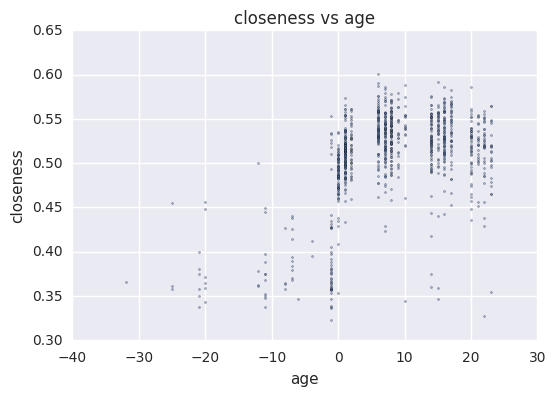

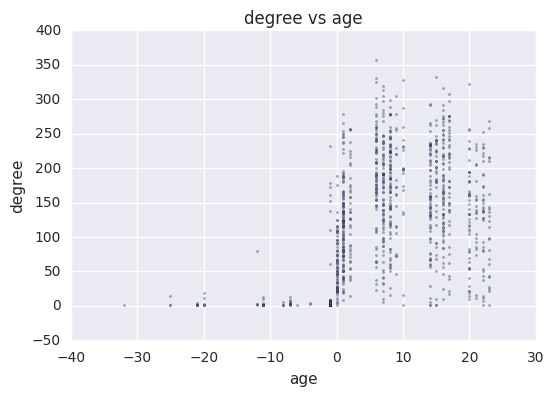

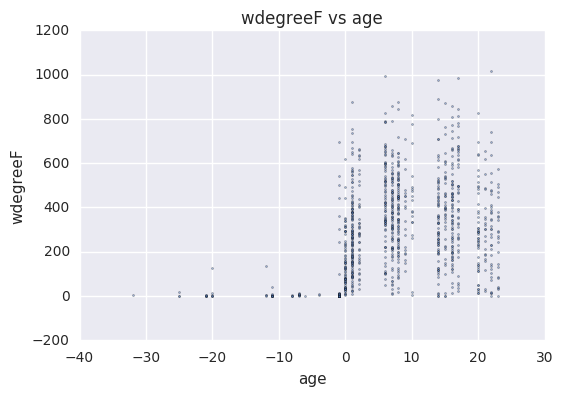

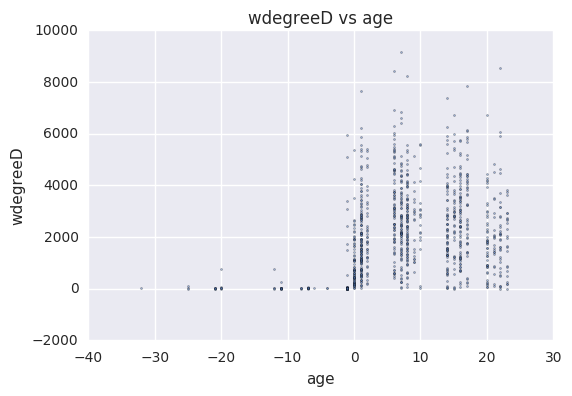

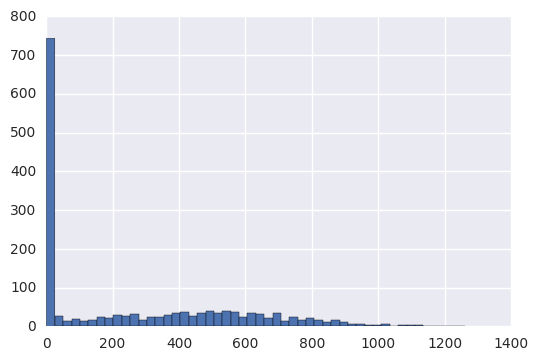

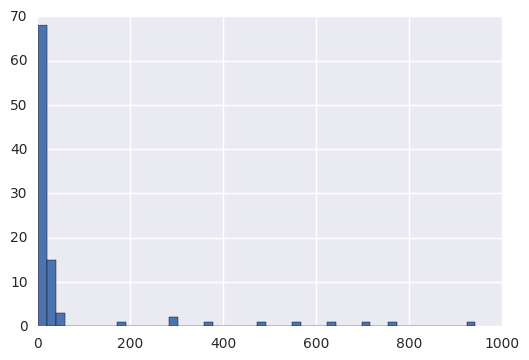

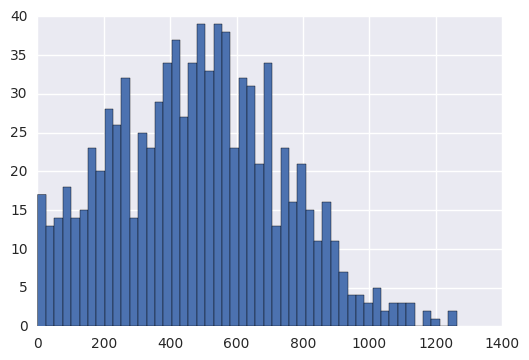

In [43]:
plotting(ids95, w95, c95, g95)

# Edge weights

In [44]:
duration = []
frequency = []
for a,b in g95.edges_iter():
    data = g95.get_edge_data(a,b)
    frequency.append(data.get('frequency'))
    duration.append(data.get('totalduration'))

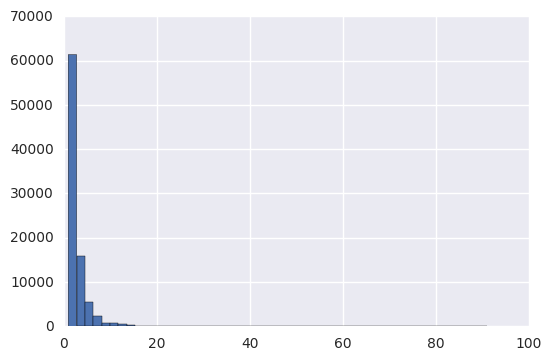

In [46]:
Series(frequency).hist(bins=50)

## Kanten mit Gewicht = 1 (frequency) wegschmeißen

In [47]:
for e in g95.edges():
    if (g95.get_edge_data(e[0],e[1]).get("frequency") < 2):
        g95.remove_edge(e[0],e[1])

In [48]:
# only for biggest subgraph
Gcc = sorted(nx.connected_component_subgraphs(g95), key = len, reverse=True)
print("Number of components: {}".format(len(Gcc)))

size_components = []
for comp in Gcc:
    size_components.append(nx.number_of_nodes(comp))
    
Counter(list(size_components))

Number of components: 591


Counter({1: 590, 1058: 1})

In [50]:
len(list(g95.nodes()))

1648

# Pipeline 5 Minuten gucken Closeness

In [96]:
s = "2016-07-21T15:00:00Z"
s_dt = datetime.datetime.strptime(s, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=pytz.UTC)
s_ts = s_dt.timestamp()
e_dt = s_dt + datetime.timedelta(minutes=5)
e_ts = e_dt.timestamp()

In [97]:
path = "/mnt/data2016/"
b = s_ts
e = e_ts
confidence = 0.95
distance = 212
ilen = 3
year = 2016
gap = 2
cutoff = 10

In [56]:
interactions = pfp.generate_network(0, path, b, e, confidence, distance, ilen, year, gap, cutoff)
    

#0 DF-0: (106561, 10), 2016-07-21 16:00:00+00:00, 2016-07-21 16:05:00+00:00
#0 DF-1: (130506, 10), 2016-07-21 16:00:00+00:00, 2016-07-21 16:05:00+00:00
#0 DF-2: (136806, 10), 2016-07-21 16:00:00+00:00, 2016-07-21 16:05:00+00:00
#0 DF-3: (124921, 10), 2016-07-21 16:00:00+00:00, 2016-07-21 16:05:00+00:00


In [58]:
g = prep.create_graph2(interactions)

In [59]:
nx.info(g)

'Name: \nType: Graph\nNumber of nodes: 751\nNumber of edges: 8874\nAverage degree:  23.6325'

In [91]:
w, c, ids = getDFstat(g)

In [94]:
len(w)

49

In [95]:
49/751

0.06524633821571238

In [92]:
ids.head()

,id,age,degree,wdegreeF,wdegreeD,closeness
0,3,15,2,5,40,0.287026
1,6,2,18,42,371,0.367647
2,10,17,25,54,425,0.371655
3,12,10,21,28,234,0.369458
4,2061,6,28,68,471,0.371287


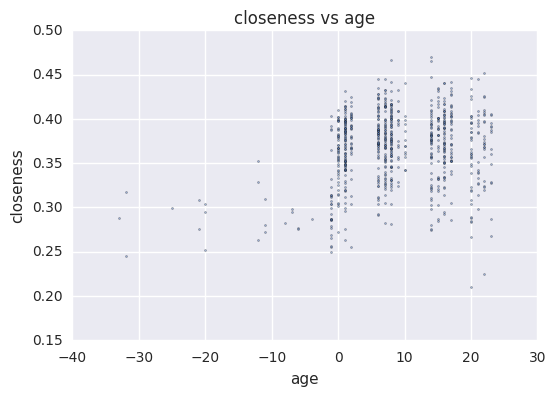

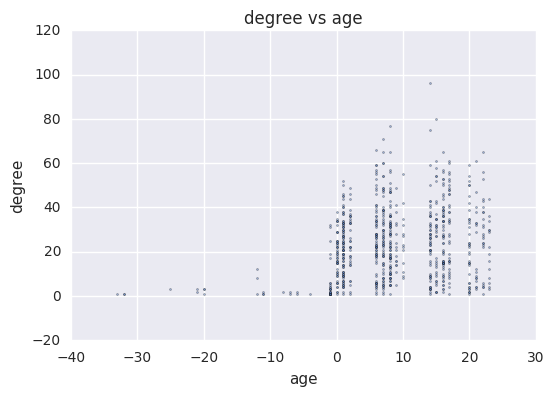

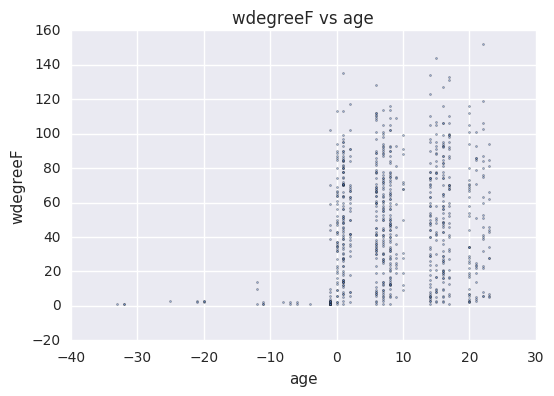

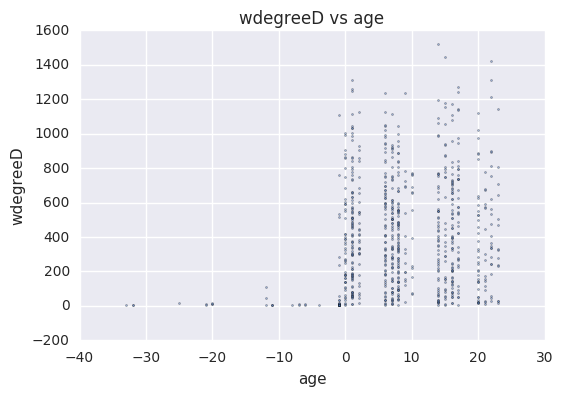

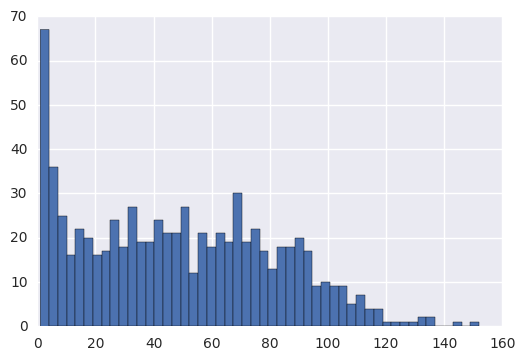

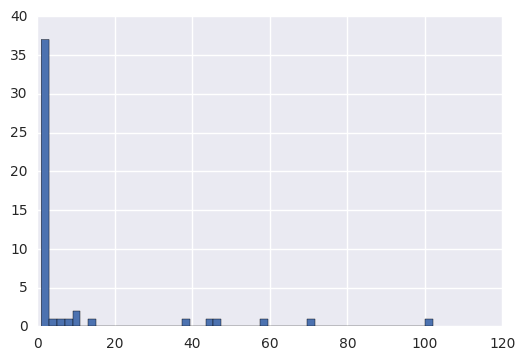

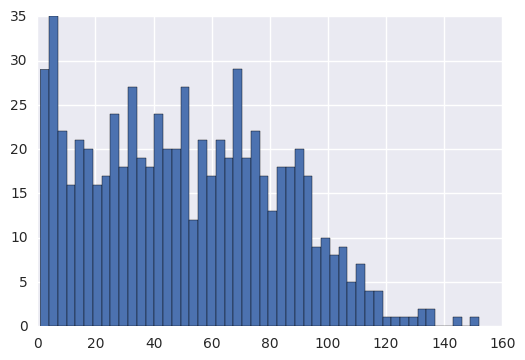

In [93]:
plotting(ids, w, c, g)

# Plot IDs VS Confidence

In [123]:
def getDetections(path, b, e, confidence, year):
    
    repo = Repository(path)
    xmax = 3000
    offset = 200
    
    Detection = namedtuple('Detection',
                           ['idx', 'xpos', 'ypos', 'radius', 'zRotation', 'decodedId', 'frame_idx', 'timestamp', 'cam_id', 'fc_id'])
    # one df per cam
    parts = np.empty(4, dtype=object)

    for i in list(range(4)):
         
        tpls = []
        myid = 0


        for frame, fc in repo.iter_frames(begin=b, end=e, cam=i):
            for d in frame.detectionsUnion.detectionsDP:
                d = Detection(d.idx, d.xpos, d.ypos, d.radius, d.zRotation, list(d.decodedId), myid, frame.timestamp, fc.camId, fc.id)
                tpls.append(d)
            myid += 1
        
        df = DataFrame(tpls)
        df = prep.calcIds(df, confidence, year)
        parts[i] = df

    # Seiten zusammenfugen
    all = pd.concat([parts[0], parts[1], parts[2], parts[3]])


    return all

In [139]:
s = "2016-07-27T16:00:00Z"
s_dt = datetime.datetime.strptime(s, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=pytz.UTC)
s_ts = s_dt.timestamp()
e_dt = s_dt + datetime.timedelta(minutes=5)
e_ts = e_dt.timestamp()

In [140]:
aa = ht.get_all_bees_age(s_dt)

In [147]:
det = getDetections(path, s_ts, e_ts, 0.1, year)

In [148]:
det.head()

,idx,xpos,ypos,radius,zRotation,frame_idx,timestamp,cam_id,fc_id,confidence,id
0,0,89,1826,22.783831,0.304799,0,1.469635e+09,0,17616259931473168059,1.000000,3918
1,1,113,861,22.574800,0.750284,0,1.469635e+09,0,17616259931473168059,0.984314,4085
2,2,239,2212,22.863508,0.360336,0,1.469635e+09,0,17616259931473168059,1.000000,2886
3,3,387,1724,23.175802,-1.980267,0,1.469635e+09,0,17616259931473168059,1.000000,893
4,4,387,2174,22.894974,-2.373598,0,1.469635e+09,0,17616259931473168059,1.000000,3207


In [149]:
dets = DataFrame(det.groupby(by='id').size(), columns=['frequ']).reset_index()
dets["age"] = dets.id.apply(lambda x: aa.iloc[x].age)

In [151]:
dets[dets.age < 0].shape

(1929, 3)

In [152]:
dets[dets.age < 0].shape[0]/dets.shape[0]

0.47806691449814126

In [166]:
detIDstat = []
for i in np.arange(0,1.01, 0.01)[-11:]:
    det = getDetections(path, s_ts, e_ts, i, year)
    dets = DataFrame(det.groupby(by='id').size(), columns=['frequ']).reset_index()
    dets["age"] = dets.id.apply(lambda x: aa.iloc[x].age)
    
    n = dets[dets.age < 0].shape[0]/dets.shape[0]
    
    detIDstat.append({'conf':i, 'ids': dets.shape[0], 'negAge': n})

In [174]:
detIDstat.negAge *= 100

AttributeError: 'list' object has no attribute 'negAge'

In [173]:
df = DataFrame(detIDstat)

In [175]:
df.negAge *= 100

In [178]:
df.ids = df.ids/2**12

In [180]:
df.ids *= 100 

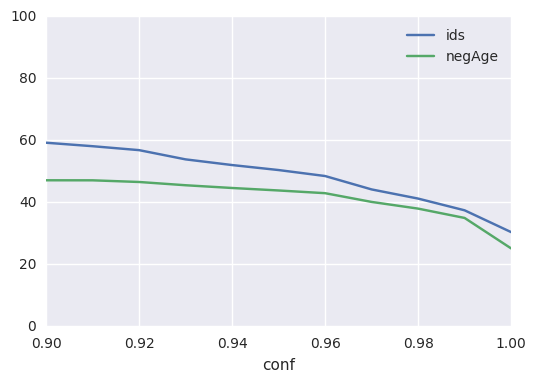

In [185]:
df.plot(x = 'conf', y=['ids', 'negAge'], ylim=(0,100))